Welcome to this Optimal Transport about Entropic Maps !

Let us start by importing the necessary packages !

In [1]:
!pip install jax jaxlib ott-jax
import jax
import jax.numpy as jnp
import jax.random as random
import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.5/265.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.3 MB/s eta 0:00:00


Optimal Transport and the Sinkhorn Algorithm

Before we start manipulating data, some general information about Optimal Transport, in the discrete case, and the Sinkhorn Algorithm is necessary.
Optimal Transport is a theory that allows us to compare two (weighted) points clouds  (X,a)  and  (Y,b) , where  X∈Rn×d  and  Y∈Rm×d  are the locations of the  n  (resp.  m ) points in dimension  d , and  a∈Rn ,  b∈Rm  are the weights. We ask that the total weights sum to one, i.e.  ∑ni=1ai=∑mj=1bj=1 .

The basic idea of Optimal Transport is to "transport" the mass located at points X to the mass located at points Y. We thus need to find the optimal transport plan P, amongst all the admissible ones that we note U(a,b).
We will also consider a cost function c:Rd×Rd→R and the associated cost matrix C=[c(Xi,Yj)]1≤i,j≤n,m∈Rn×m, containing the pairwise costs between the points of each point cloud X and Y.

The cost of transporting the mass is of P*C.

We want to find a transport plan P∈U(a,b) that will minimize this total cost. We thus want to solve minP∈U(a,b)∑i,j=1nCijPij=minP∈U(a,b)⟨C,P⟩.

This problem is a Linear Program: we can thus solve it using classical Linear Programming algorithms.

If P∗ is a solution to the Optimal Transport problem, we will say that P∗ is an optimal transport plan between (X,a) and (Y,b), and that P*C is the optimal transport distance between (X,a) and (Y,b).

Usually, we represent the weighted point clouds by probability measures μ=∑ni=1aiδXi and ν=∑mj=1bjδYj.

However, the previous minimization problem is rarely the one solved in practise.
Indeed, with an amount of data too large, the linear programming algorithms which have cubic complexity will take too much time to run.

In practise, we add negative entropy as a regularizer and minimize the following:
minP∈U(a,b)⟨C,P⟩+ϵ∑ijPij[log(Pij)−1]. .

In order to solve this problem, we use the Sinkhorn algortihm, which is absolutely central in Optimal Transport. The optimality conditions for the previous problem imply that a solution P∗ϵ necessarily is of the form P∗ϵ=diag(u)Kdiag(v), where K=exp(−C/ϵ) and u,v are two non-negative vectors.

P∗ϵ should verify the constraints, i.e. P∗ϵ∈U(a,b), so that
P∗ϵ1m=a and (P∗ϵ)T1n=b
which can be rewritten as
u⊙(Kv)=a and v⊙(KTu)=b

Then Sinkhorn's algorithm alternates between the resolution of these two equations, and reads at iteration t:
ut+1←aKvt and vt+1←bKTut+1
It usually starts from v0=1m and alternate the above updates until ∥ut+1⊙(Kvt+1)−a∥1+∥vt+1⊙(KTut+1)−b∥1≤τ, where τ>0 is a fixed convergence threshold. Actually, since at the end of each iteration, one exactly has vt+1⊙(KTut+1)=b, it just remains to test if ∥ut+1⊙(Kvt+1)−a∥1≤τ.

From an entropic optimal transport plan P∗ϵ, we can then approximate the optimal transport cost.

To get practical after this theoretical aspect, we first implement our own version of the Sinkhorn algorithm, to understand how it works. We will then use the OTT Sinkhorn implementation.

We first need some Synthetic data.

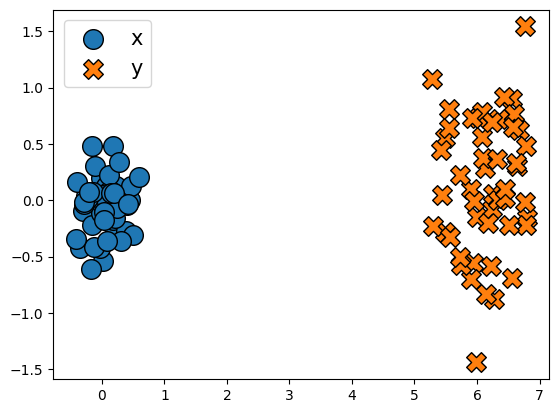

In [2]:
#synthetic data
key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)
n, m, d, b = 50, 50, 2, 6
#Source and Target
x = 0.25 * jax.random.normal(key1, (n, d))
y = 0.5 * jax.random.normal(key2, (m, d)) + jnp.array((b, 0))
#define weights
a = jnp.ones(n) / n
b = jnp.ones(m) / m

#Plotting
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", label="x", s=200)
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", label="y", s=200)
plt.legend(fontsize=15)
plt.show()

In [3]:
def sinkhornOwn(a, b, C, epsilon, max_iters=100, tau=1e-4):
    """
    Run Sinnkhorn's algorithm
    """

    # compute the kernel matrix K
    K = np.exp(-C/epsilon)

    # alternate projections onto each marginal constraint
    v = np.ones(b.shape[0])
    compteur = 0
    while np.sum(np.abs(u * K.dot(v) - a)) < tau and compteur < max_iters:
        u = a / K.dot(v)
        v = b / K.T.dot(u)
        compteur += 1

    return np.diag(u).dot(K).dot(np.diag(v))

Good ! Now let's explore OTT's own Sinkhorn implementation. We solve our problem with the following lines of code.

In [4]:
geom = pointcloud.PointCloud(x=x, y=y)
# create optimization problem
ot_prob = linear_problem.LinearProblem(geom)

# create sinkhorn solver
solver = sinkhorn.Sinkhorn(ot_prob)

# solve the OT problem
ot_sol = solver(ot_prob)

In [5]:
#Exploring the results
print("Convergence: ", ot_sol.converged)
print("Iterations to converge ", jnp.sum(ot_sol.errors > -1))
print("entropic OT cost: ",jnp.sum(ot_sol.matrix * ot_sol.geom.cost_matrix))


Convergence:  True
Iterations to converge  1
entropic OT cost:  37.567135


Now that we have explored the practical aspects of Sinkhorn and Optimal Transport, at least in the Discrete case, we need to dive deeper into Optimal Transport and Entropic Maps.

The goal of optimal transport is to find a map between two probability distributions that minimizes the squared Euclidean transportation cost. This formulation leads to what is known as the Monge problem.
\begin{equation*}
\min _{T \in \mathcal{T}(P, Q)} \int \frac{1}{2}\|x-T(x)\|_{2}^{2} \mathrm{~d} P(x) \tag{1}
\end{equation*}
where P and Q are two probability measures, and T (P, Q) is the set of admissible solutions.  A solution to the Monge problem is guaranteed to exist if P and Q have finite second moments and P is absolutely continuous.
In many samples we do not know P and Q but rather have samples  X1, . . . , Xn ∼ P and Y1, . . . , Yn ∼ Q.
There are different ways to approximate the optimal plan $T^*$. The one we will study consists in using entropic maps.
This map is built from the OT plan associated to the entropic regularized problem between $\hat{\mu}_n$ and $\hat{\nu}_n$. Let us denote $g$ and $f$ the dual potentials returned by Sinkhorn algorithm. The entropic map is then defined as follows :

$$T_{\epsilon, n}(x) = \frac{\frac{1}{n} \sum_{i=1}^n Y_i e^{\frac{1}{\epsilon} \left(g_i - \frac{1}{2} \|x - Y_i\|^2 \right)}}{\frac{1}{n} \sum_{k=1}^n e^{\frac{1}{\epsilon} \left(g_k - \frac{1}{2} \|x - Y_k\|^2 \right)}}$$

The entropic map $T_{\epsilon, n}$ allows to transport a new point $x \sim \mu$ on the $\nu$ distribution. Let us see how to implement it for specific distributions $\mu$ and $\nu$ and samples from them.



An interesting question concerns the convergence guarantees this estimator gives us. These are the main results of the corresponding paper.
To analyze the running time of this estimator, we consider the entropic map estimator obtained after k iterates of Sinkhorn’s algorithm:\\
\begin{equation*}
T^{(k)}(x)=\frac{\sum_{i=1}^{n} Y_{i} e^{\frac{1}{\varepsilon}\left(g^{(k)}\left(Y_{i}\right)-\frac{1}{2}\left\|x-Y_{i}\right\|^{2}\right)}}{\sum_{i=1}^{n} e^{\frac{1}{\varepsilon}\left(g^{(k)}\left(Y_{i}\right)-\frac{1}{2}\left\|x-Y_{i}\right\|^{2}\right)}} \tag{26}
\end{equation*}
The authors prove the following theorem, that states that T
(k) is an acceptable estimator if k is sufficiently large.
Theorem 6. Suppose assumptions (A1) to (A3) hold, and we choose $\varepsilon$ as in Theorem 3 . Then for any $k \gtrsim n^{7 /\left(d^{\prime}+\bar{\alpha}+1\right)} \log n$,

$$
\mathbb{E}\left\|T^{(k)}-T_{0}\right\|_{L^{2}(P)}^{2} \lesssim\left(1+I_{0}(P, Q)\right) n^{-\frac{(\bar{\alpha}+1)}{2\left(d^{\prime}+\bar{\alpha}+1\right)}} \log n
$$

where $d^{\prime}=2\lceil d / 2\rceil$ and $\bar{\alpha}=3 \wedge \alpha$. In particular, an estimator achieving the same rate as the estimator in Theorem 3 can be computed in $\tilde{O}\left(n^{2+7 /\left(d^{\prime}+\bar{\alpha}+1\right)}\right)=n^{2+o_{d}(1)}$ time.\\

Though the theoretical rates fall short of minimax optimal, the authors demonstrate that their estimator empirically outperforms several other statistically optimal proposals in the literature.

Time to explore how we could use the Entropic Potentials package. We first need to get the dual potential vectors from the previous solution.

In [6]:
potential_f = ot_sol.f
potential_g = ot_sol.g
print("Dual potentials for the first distribution (f):", potential_f)
print("Dual potentials for the second distribution (g):", potential_g)

Dual potentials for the first distribution (f): [ 0.07115555  0.57645845  2.8704696   6.6432023   7.457129    4.7875752
  0.61693716  3.7269874   2.8743577   2.9670568   3.4462733  -1.9750881
  4.1245685   2.795343    5.955358    1.8309598   0.6723895   1.5319219
 -1.7279677  -2.2071223  -0.33993006  1.8394732   0.8049331   3.6666913
 -2.5697188   2.7562785   0.19961834  6.317756    5.5139747   4.4458985
  7.7929864   1.2420058   4.581079    6.2317204  -0.09159231 -2.9722505
  8.1498375   2.4095902  -2.8867812   1.0450997  -0.5301604  -0.64847136
 -4.30984     0.44672012  1.8867698   2.3611665  -2.229185    4.730493
  5.2117324   5.3824744 ]
Dual potentials for the second distribution (g): [13.037739 19.274368 28.649464 30.728287 11.77132  12.746702 20.150724
 22.431688 12.178698 21.62541  27.36647  18.04263  28.720245 19.861614
 20.197754 18.647398 12.189093 20.778654 17.417562 25.82558  10.639938
 21.407862 19.87848  21.640589 15.503494 22.607101 24.106    28.549824
 23.33255  26.294

In [7]:
from ott.problems.linear import potentials
# Initialize EntropicPotentials with the computed dual potentials
entropic_potentials = potentials.EntropicPotentials(
    f_xy=potential_f,
    g_xy=potential_g,
    prob=ot_prob
)
print("Epsilon (Entropy Regularizer):", entropic_potentials.epsilon)
print("Dual Potential Function f:", entropic_potentials.f)
print("Dual Potential Function g:", entropic_potentials.g)
print("Is Debiasing Applied?:", entropic_potentials.is_debiased)

Epsilon (Entropy Regularizer): 1.8816086
Dual Potential Function f: Partial(<function EntropicPotentials._potential_fn.<locals>.callback at 0x7b8ba8468d30>, potential=Array([13.037739, 19.274368, 28.649464, 30.728287, 11.77132 , 12.746702,
       20.150724, 22.431688, 12.178698, 21.62541 , 27.36647 , 18.04263 ,
       28.720245, 19.861614, 20.197754, 18.647398, 12.189093, 20.778654,
       17.417562, 25.82558 , 10.639938, 21.407862, 19.87848 , 21.640589,
       15.503494, 22.607101, 24.106   , 28.549824, 23.33255 , 26.294956,
       14.177546, 18.053368, 26.7342  , 13.639639, 24.169615, 20.22442 ,
       24.689209, 28.294247, 26.564777, 26.399212, 24.839771, 20.614008,
       17.833303, 15.889364, 22.730284, 21.993263, 18.14499 , 26.233208,
       13.939344, 15.637455], dtype=float32), y=Array([[ 5.4858713e+00,  5.5214477e-01],
       [ 6.0108681e+00,  7.3298138e-01],
       [ 6.7966752e+00, -1.5442282e-01],
       [ 6.7740068e+00,  1.5430030e+00],
       [ 5.2877016e+00,  1.0772449e+0

We have thus obtained dual potentials functions ! Let us visualize these two for out source distribution and our target distribution.

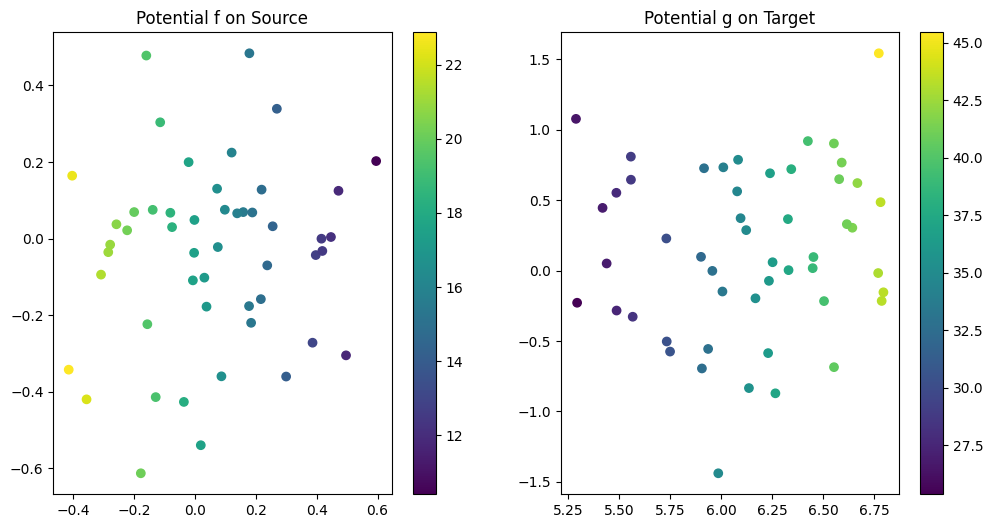

In [8]:
# Assuming f and g are your potential functions obtained from fitting your OT model
f_values = entropic_potentials.f(x)
g_values = entropic_potentials.g(y)

# Quick visualization using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 1], c=f_values, cmap='viridis')
plt.colorbar()
plt.title('Potential f on Source')

plt.subplot(1, 2, 2)
plt.scatter(y[:, 0], y[:, 1], c=g_values, cmap='viridis')
plt.colorbar()
plt.title('Potential g on Target')
plt.show()

There are various methods available in the EntropicPotentials package.

Distance between the two distributions:  52.321182


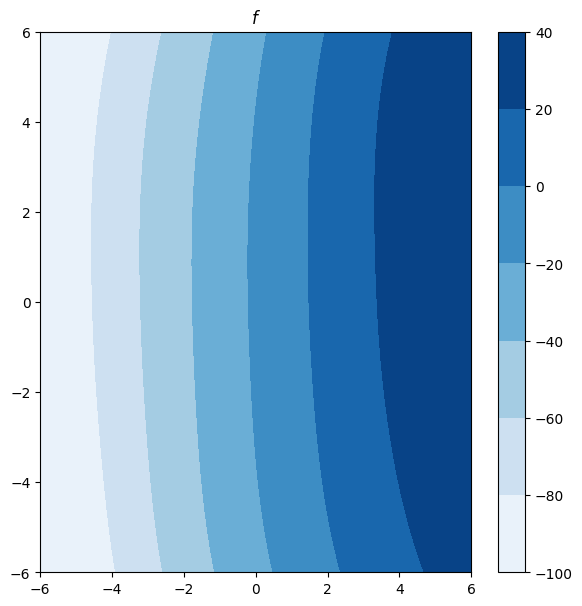

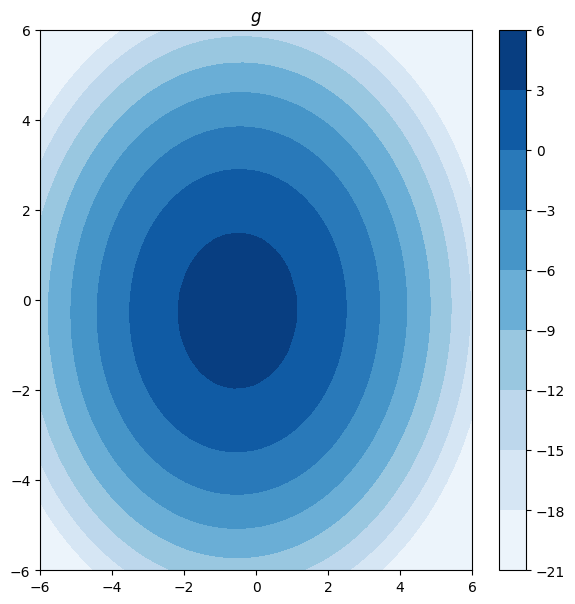

In [9]:
#We can compute the distance between the two distributions
dist = entropic_potentials.distance(x, y)
print("Distance between the two distributions: ", dist)

#We can also plot our two potential functions
pltpot = entropic_potentials.plot_potential()
pltpot2 = entropic_potentials.plot_potential(forward=False)

We would like to generate out-of-sample points to test our potential functions

In [10]:
# Generate new keys for out-of-sample data
key3, key4 = jax.random.split(jax.random.PRNGKey(1), 2)  # New keys with a different initial seed
n, m, d, b = 50, 50, 2, 6
# Generating out-of-sample datasets
x_out = 0.25 * jax.random.normal(key3, (n, d))  # Out-of-sample source points
y_out = 0.5 * jax.random.normal(key4, (m, d)) + jnp.array([b, 0])  # Out-of-sample target points

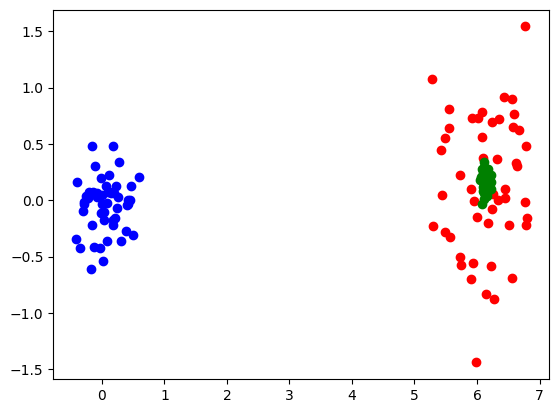

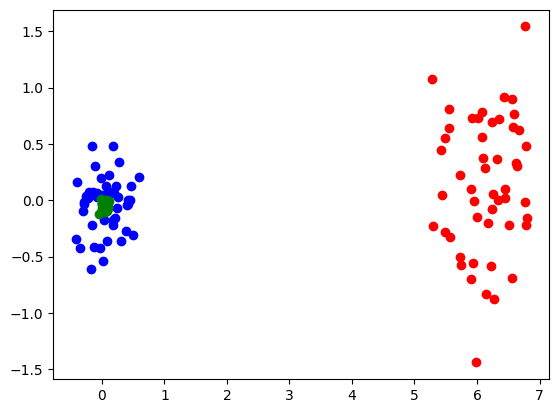

In [11]:
#Let us transport these new points both forward and backward
#transport method, forward case
trans_for = entropic_potentials.transport(x_out)
#Let us plot these transported points
plt.scatter(x[:, 0], x[:, 1], color='blue', label='Source')
plt.scatter(y[:, 0], y[:, 1], color='red', label='Target')
plt.scatter(trans_for[:, 0], trans_for[:, 1], color='green', label='Transported points forward')
plt.show()
#transport method, backward case
trans_back = entropic_potentials.transport(y_out, forward=False)
#Let us plot these transported points
plt.scatter(x[:, 0], x[:, 1], color='blue', label='Source')
plt.scatter(y[:, 0], y[:, 1], color='red', label='Target')
plt.scatter(trans_back[:, 0], trans_back[:, 1], color='green', label='Transported points backward')
plt.show()

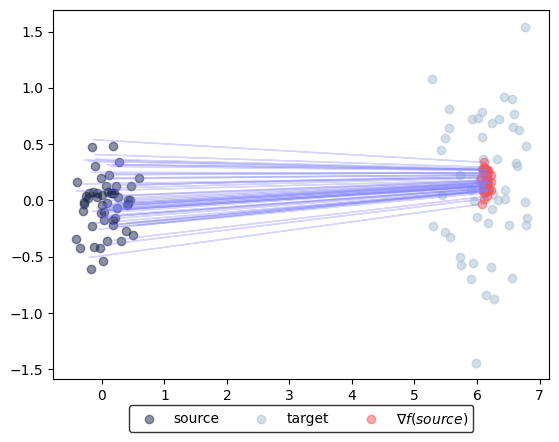

In [12]:
#plot_ot_map
map = entropic_potentials.plot_ot_map(x, y, samples=x_out)

We would next like to explore the Dual_Potentials package ie do similar things on probability distributions. We thus first need to generate continuous distribution data. We will work on gaussians.

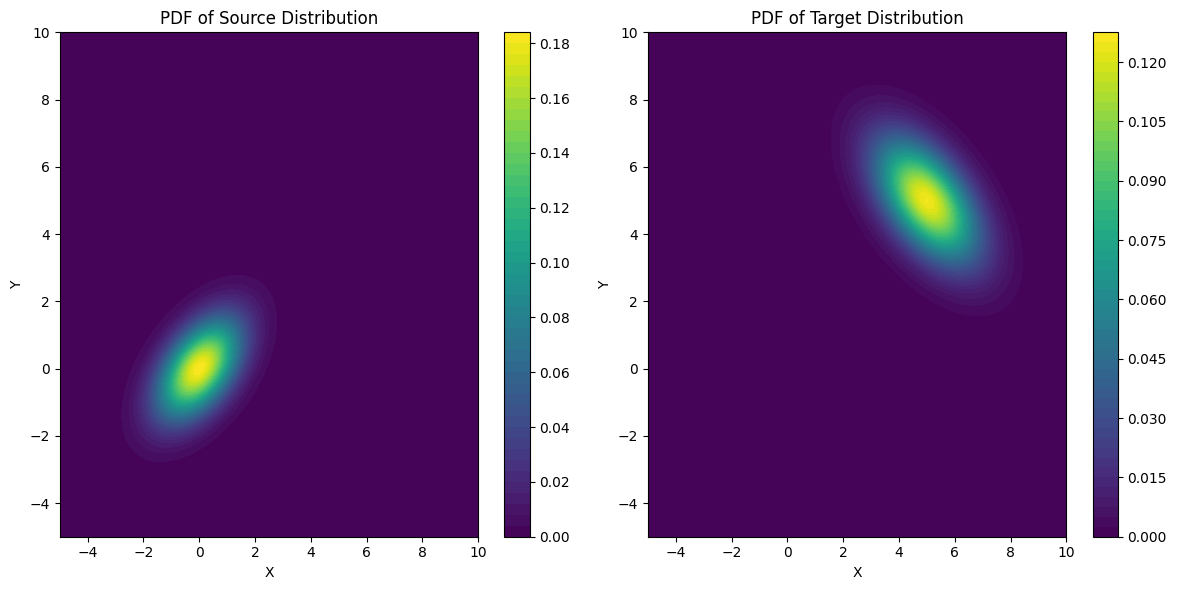

In [13]:
from scipy.stats import multivariate_normal

# Define parameters for the Gaussian distributions
mean_src = [0, 0]
cov_src = [[1, 0.5], [0.5, 1]]  # Covariance matrix for source

mean_tgt = [5, 5]
cov_tgt = [[1.5, -0.8], [-0.8, 1.5]]  # Covariance matrix for target

# Create multivariate normal distributions
dist_src = multivariate_normal(mean=mean_src, cov=cov_src)
dist_tgt = multivariate_normal(mean=mean_tgt, cov=cov_tgt)

# Define the PDF functions
def pdf_src(x, y):
    return dist_src.pdf(np.dstack((x, y)))

def pdf_tgt(x, y):
    return dist_tgt.pdf(np.dstack((x, y)))

# Generate a grid of x, y values
x = np.linspace(-5, 10, 100)
y = np.linspace(-5, 10, 100)
X, Y = np.meshgrid(x, y)

# Calculate the PDF values over the grid
Z_src = pdf_src(X, Y)
Z_tgt = pdf_tgt(X, Y)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z_src, levels=50, cmap='viridis')
plt.colorbar()
plt.title('PDF of Source Distribution')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z_tgt, levels=50, cmap='viridis')
plt.colorbar()
plt.title('PDF of Target Distribution')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()


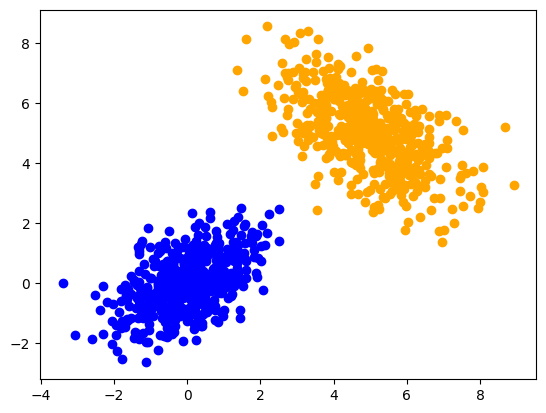

In [14]:
# Sample from the distribution
num_samples = 500
src_samples = dist_src.rvs(size=num_samples)
tgt_samples = dist_tgt.rvs(size=num_samples)

# Create a point cloud geometry from samples
geometry = pointcloud.PointCloud(src_samples, tgt_samples, cost_fn=costs.Euclidean())
#Plotting
plt.scatter(src_samples[:, 0], src_samples[:, 1], color='blue')
plt.scatter(tgt_samples[:, 0], tgt_samples[:, 1], color='orange')
plt.show()

In [15]:
# create optimization problem
ot_prob = linear_problem.LinearProblem(geometry)

# create sinkhorn solver
solver = sinkhorn.Sinkhorn(ot_prob)

# solve the OT problem
ot_sol = solver(ot_prob)
potential_f2 = ot_sol.f
potential_g2 = ot_sol.g

In [16]:
#We are looking for Dual potential functions and not dual potential vectors
#here we define adapated dual potential functions to our gaussian data
def f(x):
    """ Quadratic dual potential function for the source distribution.
        x: numpy array of shape (n, d), where n is the number of points and d is the dimension.
    """
    # Assuming a simple form where A is identity matrix and ignoring linear and constant terms
    return -0.5 * np.sum(x**2, axis=0)

def g(y):
    """ Quadratic dual potential function for the target distribution.
        y: numpy array of shape (n, d), where n is the number of points and d is the dimension.
    """
    # Similarly assuming a simple form where D is identity matrix
    return -0.5 * np.sum(y**2, axis=0)
cost_fn = costs.SqEuclidean()


dual_potentials = potentials.DualPotentials(f=f, g=g, cost_fn=cost_fn)



Let us now test some methods associated to this DualPotentials Package

52.321182


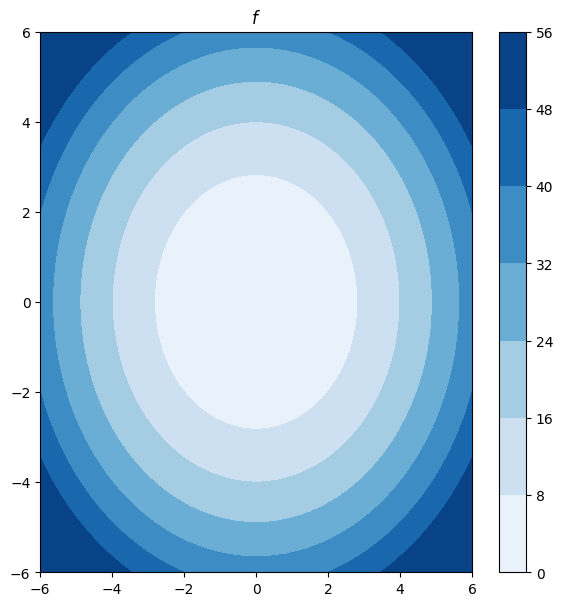

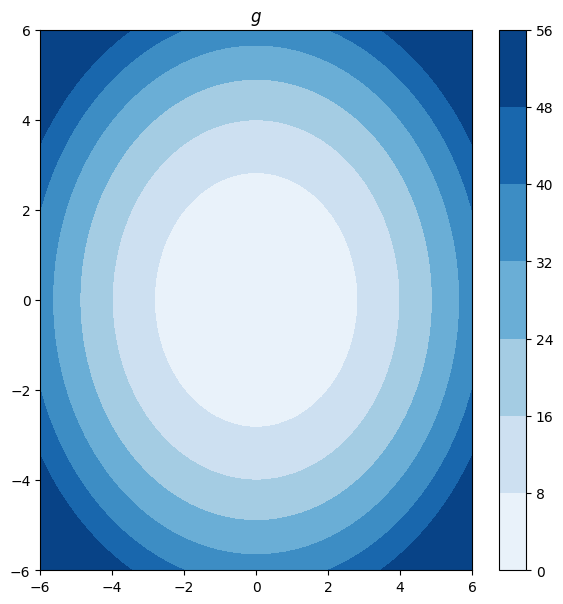

In [17]:
#distance method
dist2 = dual_potentials.distance(src_samples, tgt_samples)
print(dist)
pot_for = dual_potentials.plot_potential()
pot_back = dual_potentials.plot_potential(forward=False)

We again need to generate out_of_samples data

In [18]:
# Number of samples to generate
num_samples = 100

# Generate out-of-sample points for the source distribution
out_sample_src = np.random.multivariate_normal(mean_src, cov_src, num_samples)

# Generate out-of-sample points for the target distribution
out_sample_tgt = np.random.multivariate_normal(mean_tgt, cov_tgt, num_samples)

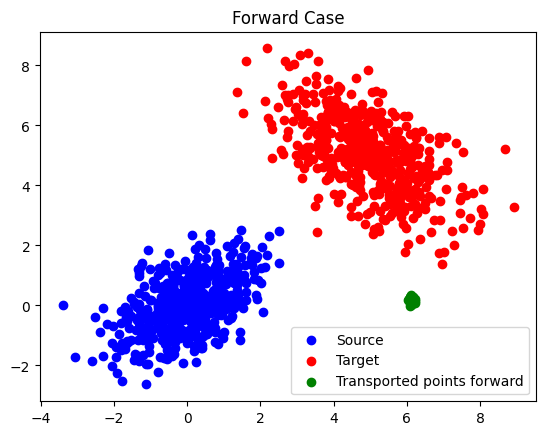

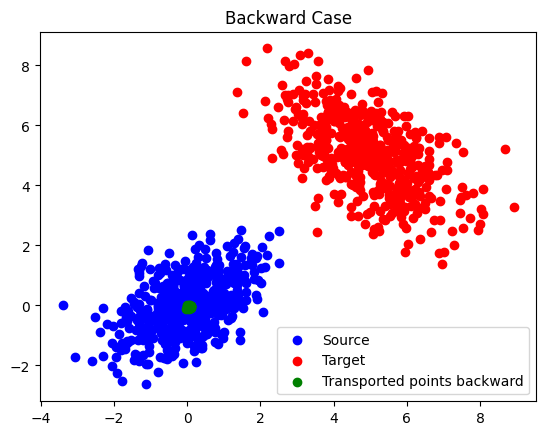

In [19]:
#transport method, forward case
trans_for2 = dual_potentials.transport(out_sample_src)
#Let us plot these transported points
plt.scatter(src_samples[:, 0], src_samples[:, 1], color='blue', label='Source')
plt.scatter(tgt_samples[:, 0], tgt_samples[:, 1], color='red', label='Target')
plt.scatter(trans_for[:, 0], trans_for[:, 1], color='green', label='Transported points forward')
plt.title("Forward Case")
plt.legend()
plt.show()
#transport method, forward case
trans_back2 = dual_potentials.transport(out_sample_tgt, forward=False)
#Let us plot these transported points
plt.scatter(src_samples[:, 0], src_samples[:, 1], color='blue', label='Source')
plt.scatter(tgt_samples[:, 0], tgt_samples[:, 1], color='red', label='Target')
plt.scatter(trans_back[:, 0], trans_back[:, 1], color='green', label='Transported points backward')
plt.title("Backward Case")
plt.legend()
plt.show()

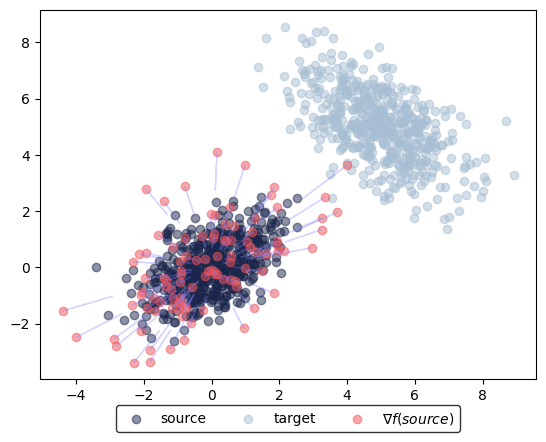

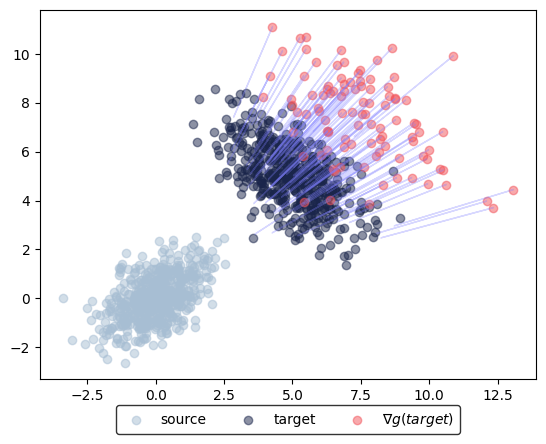

In [20]:
map2 = dual_potentials.plot_ot_map(src_samples, tgt_samples, samples=out_sample_src)
map3 = dual_potentials.plot_ot_map(src_samples, tgt_samples, samples=out_sample_tgt, forward=False)

It does not seem to work particularly well.

Another example of Entropic Maps.

---



Let us generate some new data for this.

In [21]:
n_source = 50
n_target = 50
n_test = 10
p = 2

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 4)
x = jax.random.normal(keys[0], (n_source, p)) #the source is drawn from a Gaussian distribution

y0 = jax.random.normal(keys[1], (n_target // 2, p)) + jnp.array([5, 0]) #the target is a mixture of two gaussians
y1 = jax.random.normal(keys[2], (n_target // 2, p)) + jnp.array([0, 5])
y = jnp.concatenate([y0, y1])
x_new = jax.random.normal(keys[3], (n_test, p)) #new points to be transported

We first compute the “standard” entropic map between these two distributions. We first compute the solution of Sinkhorn on the problem, and then use OTT to turn these solutions into a pair of dual potentials functions.

These dual potentials are then used to build the entropic map with the transport() method.

In [22]:
# jit first a Sinkhorn solver.
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport


map = entropic_map(x, y, costs.SqEuclidean()) #we start with the standard cost function
z = map(x_new)

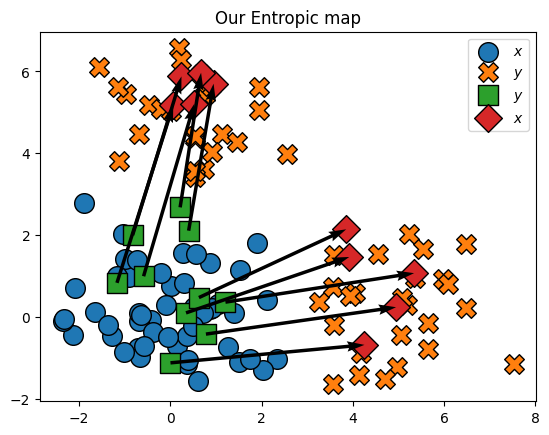

In [23]:
plt.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
plt.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
plt.scatter(*x_new.T, s=200, edgecolors="k", marker="s", label=r"$y$")
plt.scatter(*z.T, s=200, edgecolors="k", marker="D", label=r"$x$")
plt.quiver(*x_new.T,*(z - x_new).T,color="k",angles="xy",scale_units="xy",scale=1,width=0.007)
plt.title('Our Entropic map')
plt.legend()
plt.show()

Time to reproduce some of the experiments of the paper. We would like to demonstrate the computational efficiency of our estimator, and notably how its runtime scales with the number of samples of the data.

In [24]:
# function to sample from the uniform distribution over [−1,1]^d
def sample_source_distribution(key, d, n_samples):
    # Samples are uniformly distributed in the range [-1, 1] in each dimension
    return random.uniform(key, (n_samples, d), minval=-1, maxval=1)

#define the optimal transport map as the exponential function coordinate-wise
def transport_map_T0(x):
    # Apply the exponential function to each coordinate
    return jnp.exp(x)

def transport_map_T1(x):
    # Apply the exponential function to each coordinate
    return 3 * x**2 * jnp.sign(x)


In [25]:
# Dimension of the space and number of samples to generate
d = 2
n_samples = 1000

# Create a random key
key = random.PRNGKey(0)

# Sample from the source distribution
source_samples = sample_source_distribution(key, d, n_samples)

# Apply the transport map to source samples to get target samples
target_samples = transport_map_T0(source_samples)
target_samples2 = transport_map_T1(source_samples)


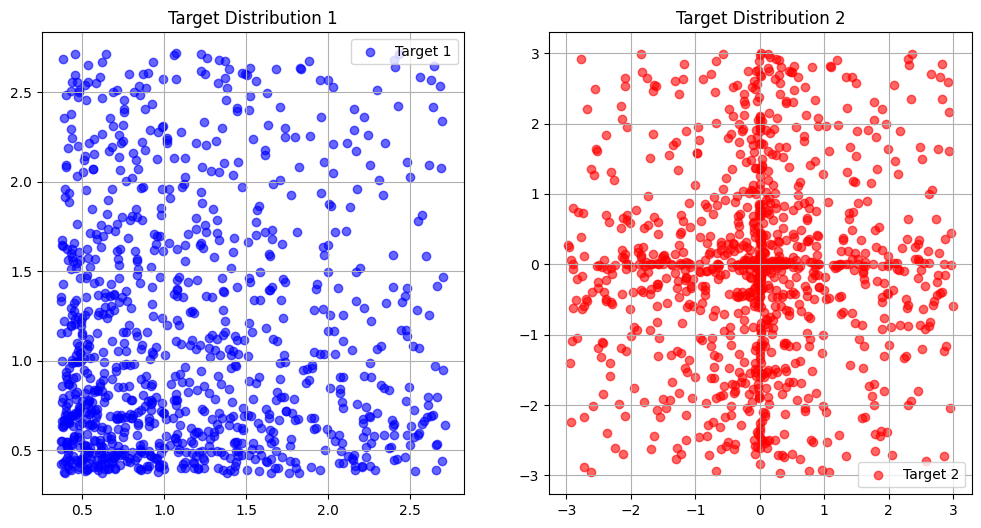

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(target_samples[:, 0], target_samples[:, 1], color='blue', alpha=0.6, label='Target 1')
plt.title('Target Distribution 1')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(target_samples2[:, 0], target_samples2[:, 1], color='red', alpha=0.6, label='Target 2')
plt.title('Target Distribution 2')
plt.grid(True)
plt.legend()

plt.show()


In [27]:
#Generate out of samples data
key_out = random.PRNGKey(1)  # Out-of-sample key to differentiate the randomness
n_samples_out = 100  # Number of out-of-sample data points

out_of_sample_data = sample_source_distribution(key_out, d, n_samples_out)

# Get the exact target samples
out_of_sample_target = transport_map_T0(out_of_sample_data)
out_of_sample_target2 = transport_map_T1(out_of_sample_data)


Let us now define our estimator

In [28]:
map2 = entropic_map(source_samples, target_samples, costs.SqEuclidean()) #we use the standard cost function
map3 = entropic_map(source_samples, target_samples2, costs.SqEuclidean()) #we use the standard cost function
z = map2(out_of_sample_data)
z2 = map3(out_of_sample_data)

Next we visualize the output of our estimator in d=2. We can compare our estimator and the true map on these additional out_of_sample points.

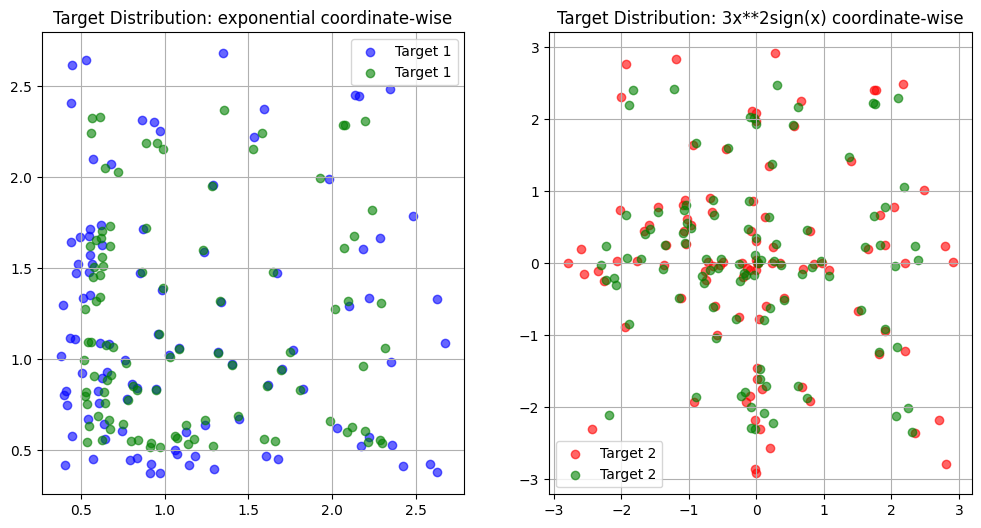

In [29]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(out_of_sample_target[:, 0], out_of_sample_target[:, 1], color='blue', alpha=0.6, label='Target 1')
plt.scatter(z[:, 0], z[:, 1], color='green', alpha=0.6, label='Target 1')
plt.title('Target Distribution: exponential coordinate-wise')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(out_of_sample_target2[:, 0], out_of_sample_target2[:, 1], color='red', alpha=0.6, label='Target 2')
plt.scatter(z2[:, 0], z2[:, 1], color='green', alpha=0.6, label='Target 2')
plt.title('Target Distribution: 3x**2sign(x) coordinate-wise')
plt.grid(True)
plt.legend()

plt.show()

Let us vary d and n and track runtime performance of our estimator

In [30]:
from sklearn.metrics import mean_squared_error
import time
#We have already defined our estimator in map2
def simulate_estimator(n_values, d_values, n_trials=20):
    mse_results = np.zeros((len(n_values), len(d_values)))
    time_results = np.zeros((len(n_values), len(d_values)))

    for i, n in enumerate(n_values):
      print("n")
      for j, d in enumerate(d_values):
        print("d")
        trial_mse = []
        trial_times = []
        #define our estimator
        key = random.PRNGKey(np.random.randint(0, 10000))
        source_samples = sample_source_distribution(key, d, n)
        target_samples = transport_map_T0(source_samples)
        map = entropic_map(source_samples, target_samples, costs.SqEuclidean())
        for _ in range(n_trials):
          key2 = random.PRNGKey(np.random.randint(0, 10000))
          out_of_sample_data = sample_source_distribution(key2, d, n)

          start_time = time.time()
          estimated_values = map(out_of_sample_data)
          elapsed_time = time.time() - start_time

          true_values = transport_map_T0(out_of_sample_data)
          mse = mean_squared_error(true_values, estimated_values)

          trial_times.append(elapsed_time)
          trial_mse.append(mse)

        mse_results[i, j] = np.mean(trial_mse)
        time_results[i, j] = np.mean(trial_times)
    return mse_results, time_results


In [31]:
n_values = [10, 100, 500, 1000, 5000]  # Example values for n
d_values = [2, 5, 10, 20]         # Example values for d

mse_results, time_results = simulate_estimator(n_values, d_values)


n
d
d
d
d
n
d
d
d
d
n
d
d
d
d
n
d
d
d
d
n
d
d
d
d


WARNING ! Make sure to run the following piece of code on a CPU and not on a GPU. The second plot, concerning the runtime, gives different results depending on if you run it on CPU or GPU.

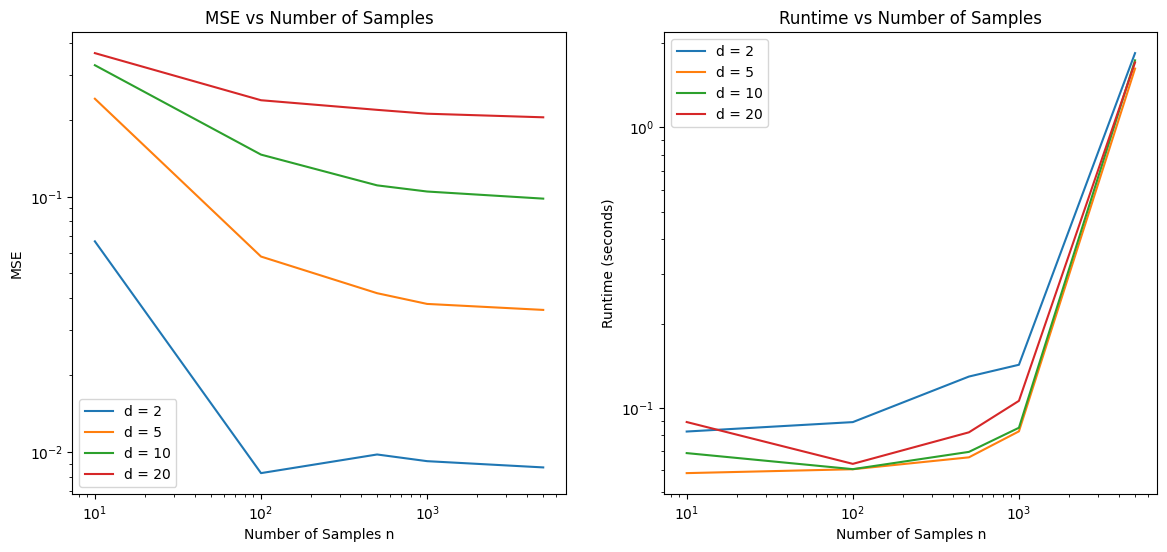

In [32]:
plt.figure(figsize=(14, 6))

# Plotting MSE results
plt.subplot(1, 2, 1)
for i, d in enumerate(d_values):
    plt.loglog(n_values, mse_results[:, i], label=f'd = {d}')
plt.title('MSE vs Number of Samples')
plt.xlabel('Number of Samples n')
plt.ylabel('MSE')
plt.legend()

# Plotting Time results
plt.subplot(1, 2, 2)
for i, d in enumerate(d_values):
    plt.loglog(n_values, time_results[:, i], label=f'd = {d}')
plt.title('Runtime vs Number of Samples')
plt.xlabel('Number of Samples n')
plt.ylabel('Runtime (seconds)')
plt.legend()

plt.show()


Clearly the computation of our estimator slows a lot for n >>10^3 when implemented on a CPU. The next piece shall be run on GPU, to attest how efficient our estimator runs on GPU.

In [33]:
n_values = [100, 500, 1000, 3000, 5000, 10000]  # Example values for n
d_values = [5, 7, 10]         # Example values for d

mse_results, time_results = simulate_estimator(n_values, d_values)

n
d
d
d
n
d
d
d
n
d
d
d
n
d
d
d
n
d
d
d
n
d
d
d


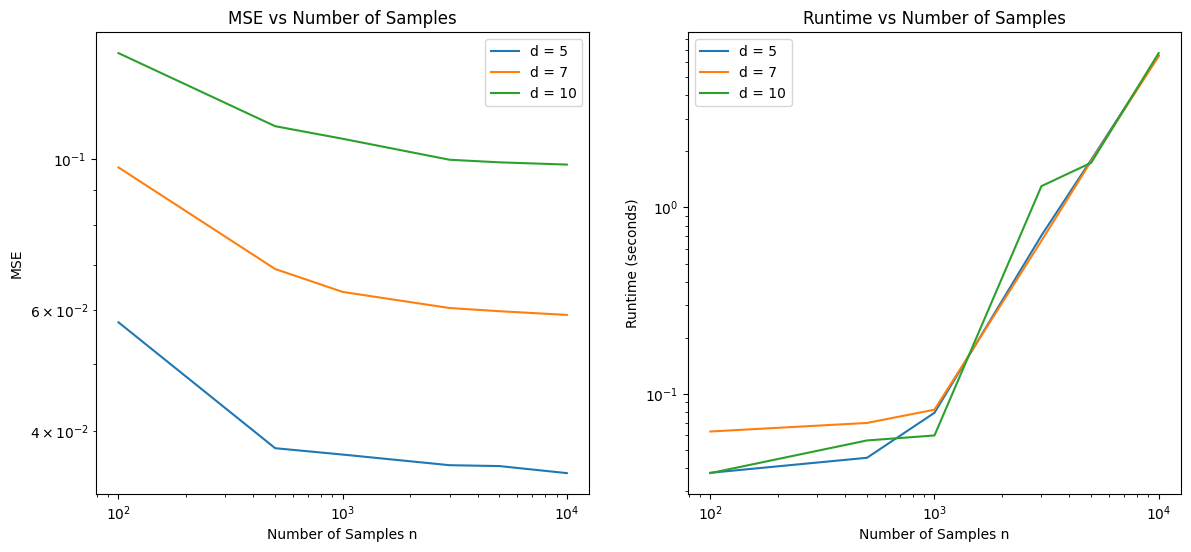

In [34]:
plt.figure(figsize=(14, 6))

# Plotting MSE results
plt.subplot(1, 2, 1)
for i, d in enumerate(d_values):
    plt.loglog(n_values, mse_results[:, i], label=f'd = {d}')
plt.title('MSE vs Number of Samples')
plt.xlabel('Number of Samples n')
plt.ylabel('MSE')
plt.legend()

# Plotting Time results
plt.subplot(1, 2, 2)
for i, d in enumerate(d_values):
    plt.loglog(n_values, time_results[:, i], label=f'd = {d}')
plt.title('Runtime vs Number of Samples')
plt.xlabel('Number of Samples n')
plt.ylabel('Runtime (seconds)')
plt.legend()

plt.show()

Our code would be even faster if we parallelized Sinkhorn's algorithm.
This estimator's big strength is that it relies on Sinkhorn's algorithm, which can be parallelized. It can thus run extremely efficiently on GPU's. When the number of samples in the data gets above 10^4, this estimator becomes much better in runtime than its competitors.

It is now time to study Real Data. We can start by briefly parallelizing Sinkhorn's algorithm on some word and texts data.

In [35]:
import io

import requests

import numpy as np

response = requests.get("https://marcocuturi.net/embeddings.npz")
data = np.load(io.BytesIO(response.content))
X, HIST = data.get("X"), data.get("HIST")

In [36]:
print(HIST[1+2, :])

[0.         0.         0.         ... 0.00613497 0.00613497 0.00613497]


In [37]:
geom = pointcloud.PointCloud(X)
cost = geom.cost_matrix
epsilon = geom.epsilon

In [38]:
from ott.solvers import linear
from ott.solvers.linear import acceleration, sinkhorn
from ott.geometry import geometry, pointcloud
n_iters = []
for i in range(13):
    n_iters.append(
        linear.solve(
            geometry.Geometry(cost_matrix=cost, epsilon=epsilon),
            lse_mode=False,
            a=HIST[0, :],
            b=HIST[1 + i, :],
        ).n_iters
    )
print(np.array(n_iters))

[60 30 40 50 60 40 60 70 40 40 40 50 40]


In [39]:
def sink(a, b, cost, epsilon, min_iterations, max_iterations):
    return linear.solve(
        geometry.Geometry(cost_matrix=cost, epsilon=epsilon),
        a=a,
        b=b,
        lse_mode=False,
        min_iterations=min_iterations,
        max_iterations=max_iterations,
    ).reg_ot_cost

In [40]:
sink_div_2vmap = jax.jit(
    jax.vmap(jax.vmap(sink, [0] + [None] * 5, 0), [None, 0] + [None] * 4, 1),
    static_argnums=[4, 5],
)

In [41]:
HIST_a = jnp.array(HIST[0:45])
HIST_b = jnp.array(HIST[-37:])
print(HIST_a.shape, HIST_b.shape, cost.shape)

(45, 4000) (37, 4000) (4000, 4000)


In [42]:
%time out_2 = DIV = sink_div_2vmap(HIST_a, HIST_b, cost, epsilon, 100, 100).block_until_ready()


KeyboardInterrupt: 

This parallelized version is definitely very fast.

In [43]:
geom = pointcloud.PointCloud(x=X)
# create optimization problem
ot_prob = linear_problem.LinearProblem(geom)

# create sinkhorn solver
solver = sinkhorn.Sinkhorn(ot_prob)

# solve the OT problem
ot_sol = solver(ot_prob)

In [44]:
f_potential = ot_sol.f
g_potential = ot_sol.g
# Initialize EntropicPotentials with the computed dual potentials
entropic_potentials = potentials.EntropicPotentials(
    f_xy=f_potential,
    g_xy=g_potential,
    prob=ot_prob
)
print("Epsilon (Entropy Regularizer):", entropic_potentials.epsilon)
print("Dual Potential Function f:", entropic_potentials.f)
print("Dual Potential Function g:", entropic_potentials.g)
print("Is Debiasing Applied?:", entropic_potentials.is_debiased)

Epsilon (Entropy Regularizer): 0.020636175
Dual Potential Function f: Partial(<function EntropicPotentials._potential_fn.<locals>.callback at 0x7b8b45852680>, potential=Array([-0.17660785, -0.17205311, -0.17127389, ..., -0.17818472,
       -0.17332375, -0.17546217], dtype=float32), y=array([[ 0.04182285, -0.03783072,  0.02529908, ...,  0.13323766,
        -0.00494963,  0.018572  ],
       [ 0.09214175,  0.03332354, -0.01348676, ..., -0.11931845,
        -0.0515989 , -0.0952983 ],
       [ 0.02432875,  0.14203905,  0.07048275, ..., -0.12062236,
        -0.01452554, -0.04613118],
       ...,
       [ 0.04733077,  0.07138353, -0.01625647, ...,  0.02168942,
        -0.01993784,  0.00302072],
       [ 0.12843494, -0.02520346,  0.09829402, ...,  0.01252838,
        -0.01074953,  0.00576056],
       [ 0.09102799,  0.07815516,  0.0518336 , ..., -0.08560374,
         0.06915928, -0.07963727]], dtype=float32), weights=Array([0.00025, 0.00025, 0.00025, ..., 0.00025, 0.00025, 0.00025],      dtype=

The computational time is low despite the data files being considerable.

It is now time to work on genes. The following requires to have the corresponding data nearby.

In [45]:
#Some preprocessing
import pandas as pd
# load proliferation and apoptosis scores
gene_set_scores = pd.read_csv('gene_set_scores.csv', index_col=0)
proliferation=gene_set_scores['Cell.cycle']
apoptosis = gene_set_scores['Apoptosis']

# apply logistic function to transform to birth rate and death rate
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f
def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by
gr = np.exp(birth-death)
growth_rates_df = pd.DataFrame(index=gene_set_scores.index, data={'cell_growth_rate':gr})
growth_rates_df.to_csv('growth_gs_init.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'gene_set_scores.csv'

In [ ]:
!pip install wot

In [ ]:
import wot
VAR_GENE_DS_PATH = 'ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = 'cell_days.txt'
SERUM_CELL_IDS_PATH = 'serum_cell_ids.txt'
CELL_GROWTH_PATH = 'growth_gs_init.txt'

# load data
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH], obs_filter=SERUM_CELL_IDS_PATH)
adata.shape

In [ ]:
# Access attributes
print(adata.X)  # Data matrix
print(adata.obs)  # Observations DataFrame
print(adata.var)  # Variables DataFrame
print(adata.obsm)  # Obs multidimensional annotations (empty initially)
print(adata.varm)  # Var multidimensional annotations (empty initially)
print(adata.uns)  # Unstructured dictionary (empty initially)
print(adata.layers)  # Additional layers of data (empty initially)

Future work would need to apply the previous packages to this data, which would first require some preprocessing. Looking ahead, it would be interesting as well to compare the results with those obtained via an Input Convex Neural Network.